In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint

from sklearn.metrics import mean_absolute_error, mean_squared_error

from datetime import datetime, date

In [2]:
def evaluate_ae(result, field, print=False):
    result = result.dropna()
    mae = mean_absolute_error(result[field], result['Lake_Level'])
    msq = mean_squared_error(result[field], result['Lake_Level'])
    if print:
        print('   MAE: {}'.format(mae))
        print('   RMAE: {}'.format(msq))
    return (field, mae, msq)

In [3]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

# df = df_raw[['Date', 'Rainfall_Cavallina', 'Temperature_Le_Croci', 'Flow_Rate', 'Lake_Level']].copy()
df = df_raw[['Date', 'Lake_Level']].copy()

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
df = df.dropna()

df['Lake_Level'] -= (251 - 31)

df

,Lake_Level
Date,
2002-06-03,29.43
2002-06-04,29.43
2002-06-05,29.43
2002-06-06,29.43
2002-06-07,29.44
...,...
2020-06-26,30.85
2020-06-27,30.84
2020-06-28,30.83


In [9]:
df['yesterday'] = df['Lake_Level'].shift(1)
df['last_week'] = df['Lake_Level'].shift(7)
df['last_month'] = df['Lake_Level'].shift(31)
df['last_year'] = df['Lake_Level'].shift(365)

df['avg_last_2D'] = df['Lake_Level'].rolling(2).mean()
df['avg_last_3D'] = df['Lake_Level'].rolling(3).mean()
df['avg_last_7D'] = df['Lake_Level'].rolling(7).mean()
df['avg_last_14D'] = df['Lake_Level'].rolling(15).mean()
df['avg_last_31D'] = df['Lake_Level'].rolling(31).mean()

df

,Lake_Level,yesterday,last_week,last_month,last_year,last_2_day_avg,last_3_day_avg,last_7_day_avg,last_14_day_avg,last_31_day_avg,avg_last_2D,avg_last_3D,avg_last_7D,avg_last_14D,avg_last_31D
Date,,,,,,,,,,,,,,,
2002-06-03,29.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-04,29.43,29.43,NaN,NaN,NaN,29.430,NaN,NaN,NaN,NaN,29.430,NaN,NaN,NaN,NaN
2002-06-05,29.43,29.43,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN
2002-06-06,29.43,29.43,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN
2002-06-07,29.44,29.43,NaN,NaN,NaN,29.435,29.433333,NaN,NaN,NaN,29.435,29.433333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,30.85,30.87,30.92,31.00,31.62,30.860,30.860000,30.868571,30.899333,30.945484,30.860,30.860000,30.868571,30.899333,30.945484
2020-06-27,30.84,30.85,30.90,31.00,31.62,30.845,30.853333,30.860000,30.892667,30.940323,30.845,30.853333,30.860000,30.892667,30.940323
2020-06-28,30.83,30.84,30.88,30.98,31.61,30.835,30.840000,30.852857,30.885333,30.935484,30.835,30.840000,30.852857,30.885333,30.935484


<AxesSubplot:xlabel='Date'>

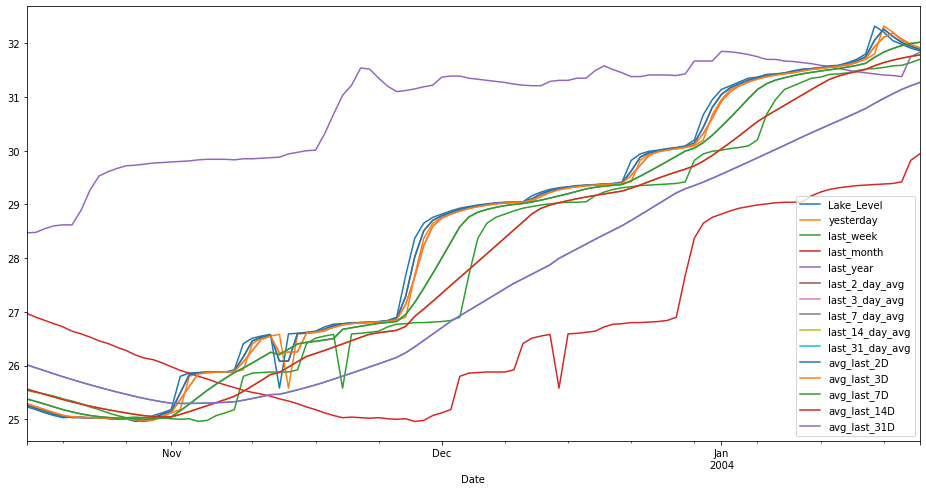

In [10]:
df[500:600].plot(figsize=(16, 8))

In [11]:
results = []

for c in df:
    if c != 'Lake_Level':
        results.append(evaluate_ae(df, c))

df_r = pd.DataFrame(results, columns=['name', 'mae', 'rmae'])
df_r = df_r.set_index('name')

df_r = df_r.sort_values(by=['mae'])

df_r

,mae,rmae
name,,
last_2_day_avg,0.023027,0.002788
avg_last_2D,0.023027,0.002788
last_3_day_avg,0.044156,0.008323
avg_last_3D,0.044156,0.008323
yesterday,0.046055,0.011152
last_7_day_avg,0.119118,0.044675
avg_last_7D,0.119118,0.044675
last_14_day_avg,0.246935,0.151705
avg_last_14D,0.246935,0.151705


<AxesSubplot:xlabel='name'>

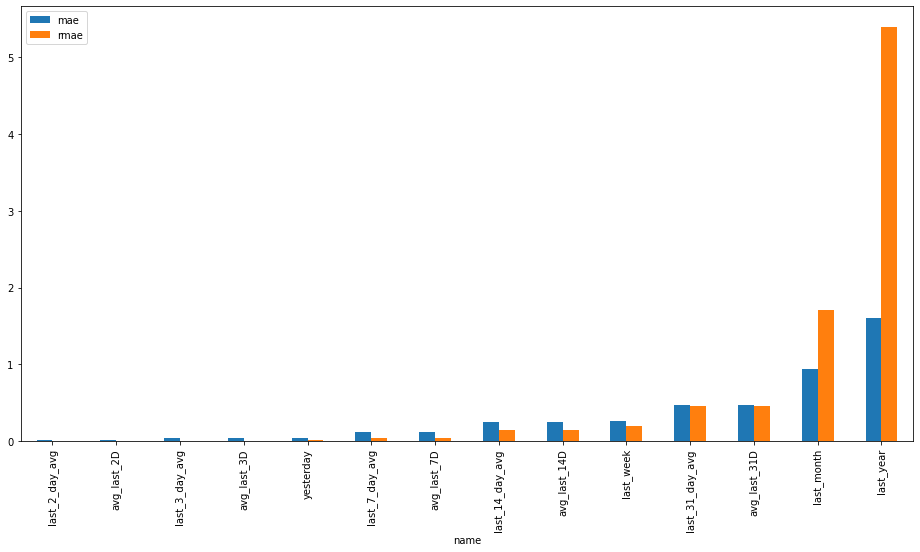

In [12]:
df_r.plot(kind='bar', figsize=(16, 8))